# Port Recognition

Very similar to scalable vertex recognition. Read that manual.

#### Learnings:
* Watch out: no white pixel in a plot does not mean that there is no white data point!!!
* Convert shapes: rsvg-convert output.svg -w 20 -h 20 -o output.png 

In [92]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objects as go


### Input and Transparency (Alpha) Management

In [93]:
activate_plotly = False
threshold = 0.35 # finds 2 ports

# Define the paths
target_image_path = 'images/testcase4.png'
# template_image_path = 'images/input.png'
template_image_path = 'images/output.png'

target_img = cv2.imread(target_image_path)
template_img_with_alpha = cv2.imread(template_image_path, cv2.IMREAD_UNCHANGED)

#### Visualization of Input

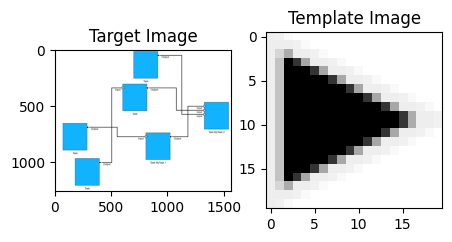

In [94]:
# plot target image and template_img_with_alpha
fig, ax = plt.subplots(1, 2, figsize=(5, 10))
ax[0].imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax[0].set_title('Target Image')
ax[1].imshow(cv2.cvtColor(template_img_with_alpha, cv2.COLOR_BGRA2RGBA))
ax[1].set_title('Template Image')
plt.show()

## Channel Management

In [95]:
# Create template_img without alpha by discarding the 4th channel
template_img = template_img_with_alpha[:, :, :3]

# Take the alpha channel of the template image and make it a mask
template_alpha_channel = template_img_with_alpha[:, :, 3]
template_alpha_mask = (template_alpha_channel > 0).astype(np.uint8) * 255 # make it a 8bit mask, binary and for compatibility reasons 8bit

# Make it a 3-channel mask, for convenience
template_alpha_mask_3 = cv2.merge([template_alpha_mask]*3)

#### Visualize Mask

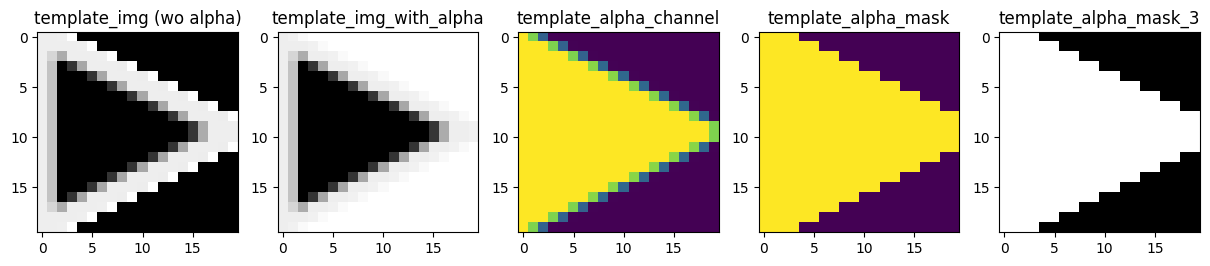

In [96]:
# plot template_img_with_alpha, template_alpha_channel, template_alpha_mask, template_alpha_mask_3
fig, ax = plt.subplots(1, 5, figsize=(15, 15))
ax[0].imshow(cv2.cvtColor(template_img, cv2.COLOR_BGR2RGB))
ax[0].set_title('template_img (wo alpha)')
ax[1].imshow(cv2.cvtColor(template_img_with_alpha, cv2.COLOR_BGRA2RGBA))
ax[1].set_title('template_img_with_alpha')
ax[2].imshow(template_alpha_channel) 
ax[2].set_title('template_alpha_channel')
ax[3].imshow(template_alpha_mask,)
ax[3].set_title('template_alpha_mask')
ax[4].imshow(template_alpha_mask_3)
ax[4].set_title('template_alpha_mask_3')
plt.show()

### Template Matching

For some reason TM_SQDIFF_NORMED is not normed to 0..1, this could be because of mask of 3 channels.

Template matching works with mask but only for the template [SO](https://stackoverflow.com/a/44693722)
Docu template matching [opencv tut](https://docs.opencv.org/3.4/de/da9/tutorial_template_matching.html)
[opencv doc](https://docs.opencv.org/3.0.0/df/dfb/group__imgproc__object.html#ga586ebfb0a7fb604b35a23d85391329be)

Great explanation why we should use a least squares the key is that on a white background you would have to problem of dividing by zero. [SO](https://stackoverflow.com/questions/44690002/python-opencv-matchtemplate-on-grayscale-image-with-masking)

In [ ]:
# Apply template matching
# res = cv2.matchTemplate(target_img, template_img, cv2.TM_CCOEFF_NORMED, mask=template_alpha_mask_3)

# res = cv2.matchTemplate(target_masked, template_img, cv2.TM_CCORR_NORMED, mask=template_alpha_mask)
# res = cv2.matchTemplate(target_masked, template_img, cv2.TM_CCOEFF_NORMED)
# res = cv2.matchTemplate(target_img, template_img, cv2.TM_SQDIFF, mask=template_alpha_mask_3 ) # working
res = cv2.matchTemplate(target_img, template_img, cv2.TM_SQDIFF_NORMED, mask=template_alpha_mask_3 ) # experiment to normalize

#### Template Matching Debug Output

In [98]:
# print max of res
print('Max of res: ', np.max(res))
# print min of res
print('Min of res: ', np.min(res))
print('Shape of res: ', res.shape)

# print shape of template and target
print('Shape of template: ', template_img.shape)
print('Shape of target: ', target_img.shape)

# print the data types
print('Data type of template: ', template_img.dtype)
print('Data type of target: ', target_img.dtype)



Max of res:  1.34913
Min of res:  0.21819654
Shape of res:  (1233, 1547)
Shape of template:  (20, 20, 3)
Shape of target:  (1252, 1566, 3)
Data type of template:  uint8
Data type of target:  uint8


#### Visualization of Template Matching

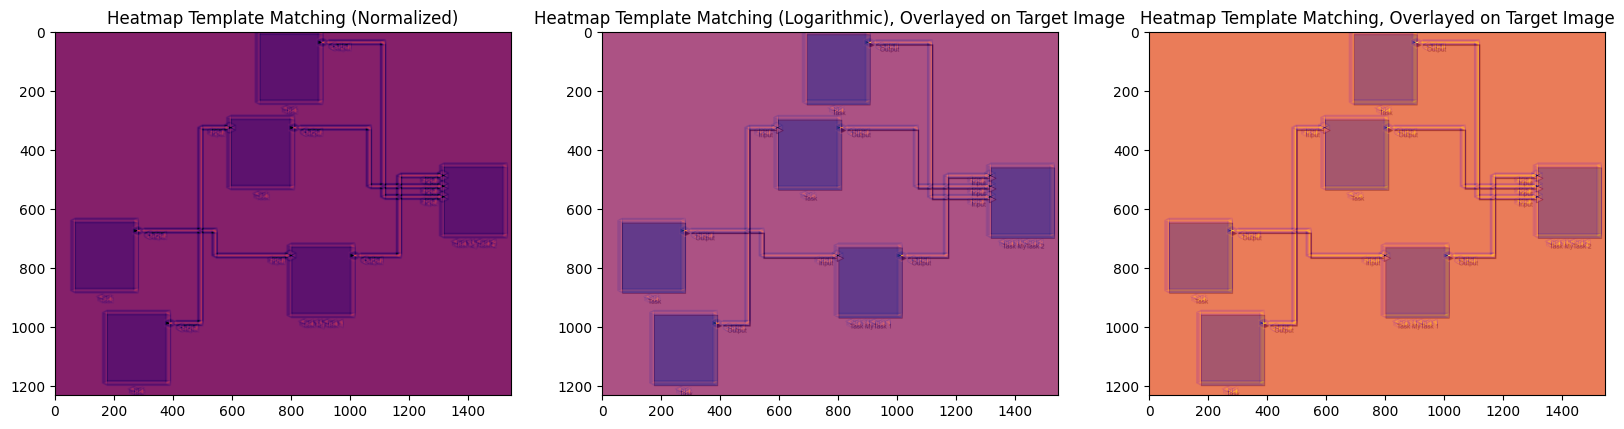

In [99]:
# Draw all heatmaps next to each other in a single plot
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Non-logarithmic heatmap
ax[0].imshow(res, cmap='inferno_r', vmin=0, vmax=1)
ax[0].set_title('Heatmap Template Matching (Normalized)')

# Logarithmic heatmap overlayed on original image
ax[1].imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax[1].imshow(np.log(res), cmap='inferno_r', alpha=0.8, interpolation='nearest')
ax[1].set_title('Heatmap Template Matching (Logarithmic), Overlayed on Target Image')

# Non-logarithmic heatmap overlayed on original image
ax[2].imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax[2].imshow(res, cmap='inferno_r', alpha=0.8, interpolation='nearest')
ax[2].set_title('Heatmap Template Matching, Overlayed on Target Image')

plt.show()

#### Visualization of Template Matching 3D with plotly with screenshot for paper

In [100]:
# template matching data processing
template_matching_result = res.copy()
# z_data = -np.log(template_matching_result[::-1])
z_data = template_matching_result[::-1]
# mirror z_data
z_data = np.flipud(z_data)

# target image data processing
target_img_cropped = target_img[:template_matching_result.shape[0], :template_matching_result.shape[1], :]
target_img_cropped_gray = cv2.cvtColor(target_img_cropped, cv2.COLOR_BGR2GRAY)
# z_image = np.ones_like(target_img_cropped_gray)*-16.8 # 16.7 is good
z_image = np.ones_like(target_img_cropped_gray)*0.8 # 0.8 is good
z_image = np.flipud(z_image)


activate_plotly = False
if activate_plotly:
    fig = go.Figure()

    # Layer 1: 3D Plot of Heatmap
    fig.add_trace(go.Surface(
        z=z_data,
        showscale=False,
        colorscale='inferno_r'
        ))

    # Layer 2: 2D Plot of Target Image at 0.1 (for aesthetics)
    fig.add_trace(go.Surface(
        z=z_image, 
        surfacecolor=target_img_cropped_gray, 
        colorscale='gray', 
        showscale=False
        ))
    
    fig.update_layout(title='Heatmap Template Matching', 
                      scene=dict(
                        yaxis=dict(autorange='reversed'),
                        zaxis=dict(autorange="reversed") 
                      ),
                      height=1500,
                      scene_aspectratio=dict(x=2, y=1, z=0.5),
                      )
    fig.show()

## Visualization after Thresholding

### Threshold Template Matching

In [101]:

# IDEA: make threshold in %, somehow related to area.
# and analyse with plotly what else is almost detected
loc = np.where(res < threshold)
print(f"Found {len(loc[0])} matches with a threshold of {threshold}")

Found 27 matches with a threshold of 0.35


### Analysis After Thresholding

In [102]:
# Set all values over the threshold to 1 (was 2e7) (which kind of resembles "zero")
thresholded_res = np.copy(res)
thresholded_res[thresholded_res > threshold] = 1

#### 2D big Xes on Target Image

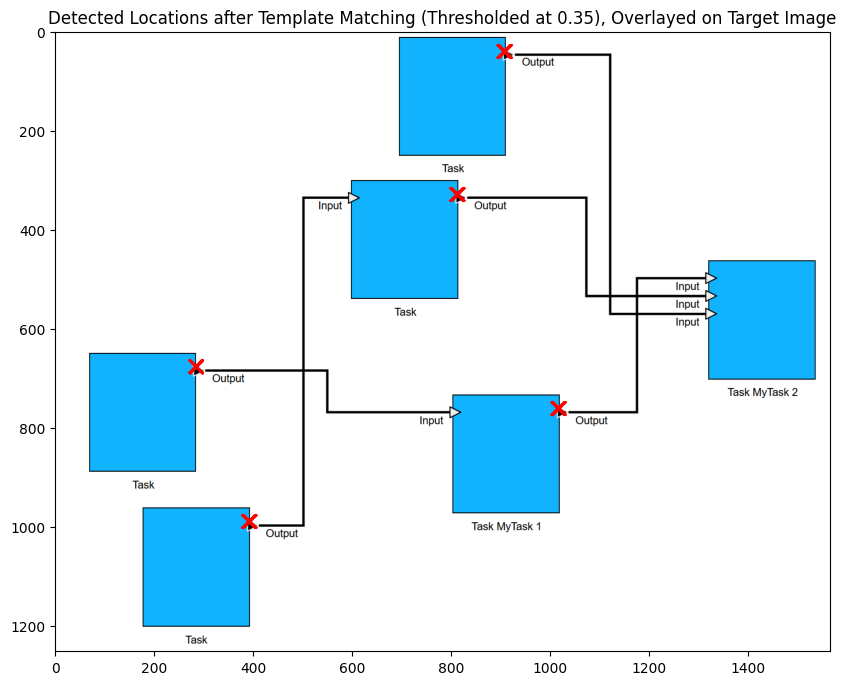

In [103]:
# draw the loc as points
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax.scatter(loc[1], loc[0], c='r', s=100, marker='x')
plt.title(f'Detected Locations after Template Matching (Thresholded at {threshold}), Overlayed on Target Image')
plt.show()

### No Foreground Filter
but small conversion of result

In [106]:
"""Case ports: no need to check for foreground. Just return the all points. Background: tranpsarent, so no need to check for foreground."""
loc_converted = []
for pt in zip(*loc[::-1]):
    loc_converted.append(pt)

print(loc_converted)

[(np.int64(906), np.int64(38)), (np.int64(907), np.int64(38)), (np.int64(908), np.int64(38)), (np.int64(909), np.int64(38)), (np.int64(910), np.int64(38)), (np.int64(910), np.int64(39)), (np.int64(810), np.int64(327)), (np.int64(811), np.int64(327)), (np.int64(812), np.int64(327)), (np.int64(813), np.int64(327)), (np.int64(814), np.int64(327)), (np.int64(284), np.int64(675)), (np.int64(282), np.int64(676)), (np.int64(283), np.int64(676)), (np.int64(284), np.int64(676)), (np.int64(285), np.int64(676)), (np.int64(284), np.int64(677)), (np.int64(1015), np.int64(760)), (np.int64(1016), np.int64(760)), (np.int64(1017), np.int64(760)), (np.int64(1018), np.int64(760)), (np.int64(1019), np.int64(760)), (np.int64(389), np.int64(989)), (np.int64(390), np.int64(989)), (np.int64(391), np.int64(989)), (np.int64(392), np.int64(989)), (np.int64(393), np.int64(989))]


### Fill bounding boxes

In [107]:
matched_templates_bbox_filled = np.zeros(target_img.shape[:2], dtype=np.uint8)
for pt in loc_converted:
    cv2.rectangle(matched_templates_bbox_filled, pt, (pt[0] + template_img.shape[1], pt[1] + template_img.shape[0]), 255, -1)

#### Plot filled bounding boxes

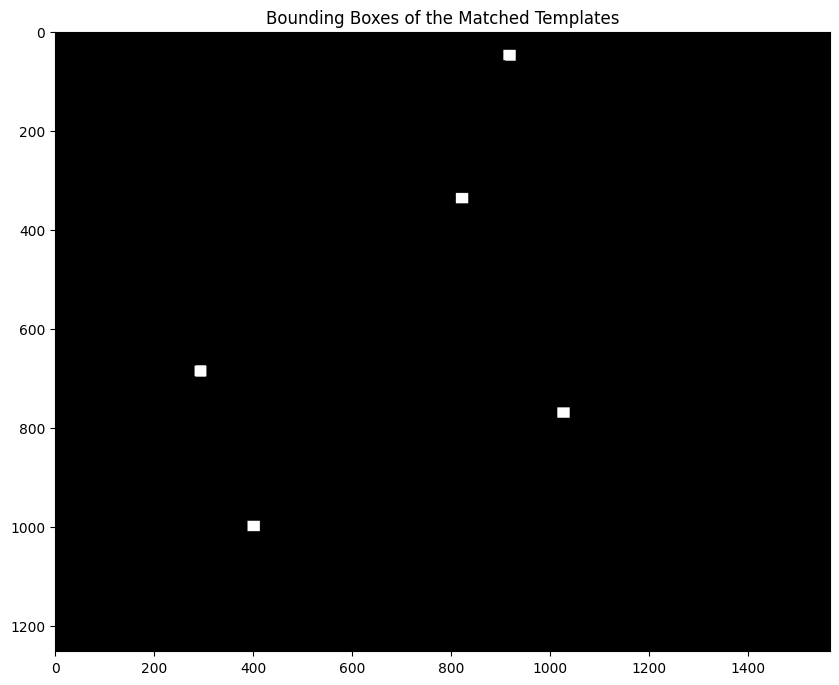

In [108]:
# Draw the result
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(matched_templates_bbox_filled, cmap='gray')
plt.title('Bounding Boxes of the Matched Templates')
plt.show()

### Find Contours in the super boxes

In [109]:
target_img_boundings_grouped = target_img.copy()

# Find contours
contours, _ = cv2.findContours(matched_templates_bbox_filled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Store the bounding boxes of the vertices
bounding_boxes = []

# Draw bounding boxes based on contours or compute their coordinates
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    cv2.rectangle(target_img_boundings_grouped, (x, y), (x+w, y+h), (125, 255, 0), 4)
    bounding_boxes.append((x, y, w, h))
print(f"bounding_boxes: {bounding_boxes}")

bounding_boxes: [(389, 989, 25, 21), (1015, 760, 25, 21), (282, 675, 24, 23), (810, 327, 25, 21), (906, 38, 25, 22)]


#### Visualize the super boxes

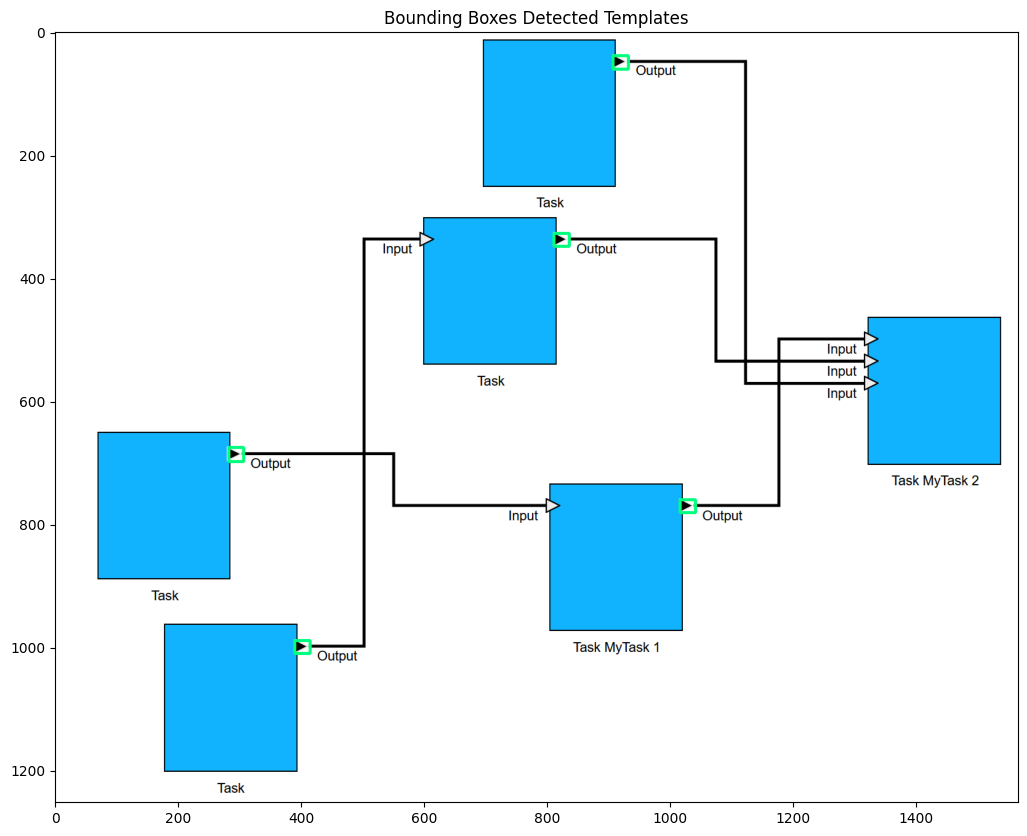

In [110]:
# Draw the result
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.imshow(cv2.cvtColor(target_img_boundings_grouped, cv2.COLOR_BGR2RGB))
ax.set_title("Bounding Boxes Detected Templates")
plt.show()